# Heart Attack Prediction Analysis

This notebook performs a heart attack prediction analysis using a dataset from Indonesia. The goal is to build a Logistic Regression model to predict the likelihood of a heart attack (`heart_attack`) based on various features.

**Dataset**: `heart_attack_prediction_indonesia.csv`

**Workflow**:
1. Load and preprocess the dataset (handle missing values, encode categorical variables, scale numerical features).
2. Perform exploratory data analysis (EDA) to understand the data.
3. Analyze correlations between features.
4. Train and evaluate Logistic Regression models using multiple experiments:
   - **Baseline**: Train on imbalanced data with `class_weight='balanced'`.
   - **SMOTE**: Train on SMOTE-resampled data.
   - **Downsampling**: Train on downsampled data.
   - **Hyperparameter Tuning**: Use GridSearchCV to find the best parameters on downsampled data.


In [1]:
# Standard library imports
import os

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    balanced_accuracy_score, 
    f1_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
import joblib

%matplotlib inline

## Load Dataset

Load the heart attack dataset from the specified CSV file.

In [2]:
def load_data():
    
    # Load dataset
    df = pd.read_csv('heart_attack_prediction_indonesia.csv')
    return df

# Load data
df = load_data()
df.head()  # Display first few rows

,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1


In [3]:
# Check missing values
print(df.isnull().sum())

age                                   0
gender                                0
region                                0
income_level                          0
hypertension                          0
diabetes                              0
cholesterol_level                     0
obesity                               0
waist_circumference                   0
family_history                        0
smoking_status                        0
alcohol_consumption               94848
physical_activity                     0
dietary_habits                        0
air_pollution_exposure                0
stress_level                          0
sleep_hours                           0
blood_pressure_systolic               0
blood_pressure_diastolic              0
fasting_blood_sugar                   0
cholesterol_hdl                       0
cholesterol_ldl                       0
triglycerides                         0
EKG_results                           0
previous_heart_disease                0


## Preprocess Data

Preprocess the dataset by:
- Handling missing values in `alcohol_consumption` by filling with 'Non-Alcoholic'.
- Encoding categorical variables:
  - Label encoding for ordered categories
  - One-hot encoding for nominal categories
  - Manual encoding for `alcohol_consumption` using the mapping: `Non-Alcoholic: 0`, `Moderate: 1`, `High: 2`.
- Scaling numerical features using `StandardScaler`, excluding the target (`heart_attack`), label-encoded columns, and `alcohol_consumption`.
- Converting the target variable (`heart_attack`) to integer type to ensure it is numeric.
- Verifying preprocessing by displaying the scaled numerical columns, the first few rows, and dataset information.

In [4]:
def preprocess_data(df):
    
    # Fill missing values in alcohol_consumption
    df['alcohol_consumption'] = df['alcohol_consumption'].fillna('Non-Alcoholic')
    print("Alcohol Consumption after filling missing values:\n", df['alcohol_consumption'])

    # Map alcohol consumption to numeric values
    alcohol_mapping = {'Non-Alcoholic': 0, 'Moderate': 1, 'High': 2}
    df['alcohol_consumption'] = df['alcohol_consumption'].map(alcohol_mapping)

    # Label encoding for ordered categorical columns
    label_cols = [
        'income_level',
        'smoking_status',
        'physical_activity',
        'air_pollution_exposure',
        'stress_level'
    ]
    le = LabelEncoder()
    for col in label_cols:
        df[col] = le.fit_transform(df[col])

    # One-hot encoding for nominal categorical columns
    one_hot_cols = ['gender', 'region', 'dietary_habits', 'EKG_results']
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

    # Ensure heart_attack is numeric
    df['heart_attack'] = df['heart_attack'].astype(int)

    # Feature scaling for numerical columns (excluding target and encoded columns)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['heart_attack'] + label_cols + ['alcohol_consumption']]
    if numerical_cols:
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        print(f"Scaled numerical columns: {numerical_cols}")

    return df

# Preprocess data
df = preprocess_data(df)
df.info()  # Display dataset info
print("\nFirst 5 rows after preprocessing:")
df.head()  # Verify encoding and scaling

Alcohol Consumption after filling missing values:
 0         Non-Alcoholic
1         Non-Alcoholic
2              Moderate
3              Moderate
4              Moderate
              ...      
158350    Non-Alcoholic
158351    Non-Alcoholic
158352         Moderate
158353    Non-Alcoholic
158354    Non-Alcoholic
Name: alcohol_consumption, Length: 158355, dtype: object
Scaled numerical columns: ['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'family_history', 'sleep_hours', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl', 'triglycerides', 'previous_heart_disease', 'medication_usage', 'participated_in_free_screening']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158355 entries, 0 to 158354
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                      

,age,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,smoking_status,alcohol_consumption,...,cholesterol_ldl,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,gender_Male,region_Urban,dietary_habits_Unhealthy,EKG_results_Normal
0,0.458088,2,-0.653202,2.001224,0.288563,-0.577197,-0.626810,-0.654993,1,0,...,-0.245463,-0.993729,-0.500898,-0.999539,-1.227375,0,True,False,True,True
1,-0.129611,1,-0.653202,-0.499694,0.213067,-0.577197,0.777156,1.526733,2,0,...,-1.333877,-0.238986,1.996415,-0.999539,0.814747,0,False,True,False,True
2,0.626002,1,-0.653202,-0.499694,0.791866,1.732510,1.143409,1.526733,2,1,...,0.012319,0.434163,-0.500898,1.000461,-1.227375,1,False,True,False,False
3,1.549529,1,1.530920,-0.499694,0.062076,-0.577197,-0.687852,1.526733,1,1,...,-1.276592,-0.075798,-0.500898,1.000461,0.814747,0,True,True,True,True
4,-0.213568,2,1.530920,-0.499694,0.817031,-0.577197,-0.260558,-0.654993,0,1,...,-0.073609,-0.218588,1.996415,-0.999539,0.814747,1,True,True,True,True


## Exploratory Data Analysis (EDA)

Perform EDA to understand the dataset:
- Check for missing values and duplicates.
- Display summary statistics for numerical columns to identify potential outliers or scaling issues.
- Check the class distribution of the target variable (`heart_attack`) to assess imbalance.
- Visualize the distribution of categorical columns.

Missing Values:
 age                               0
income_level                      0
hypertension                      0
diabetes                          0
cholesterol_level                 0
obesity                           0
waist_circumference               0
family_history                    0
smoking_status                    0
alcohol_consumption               0
physical_activity                 0
air_pollution_exposure            0
stress_level                      0
sleep_hours                       0
blood_pressure_systolic           0
blood_pressure_diastolic          0
fasting_blood_sugar               0
cholesterol_hdl                   0
cholesterol_ldl                   0
triglycerides                     0
previous_heart_disease            0
medication_usage                  0
participated_in_free_screening    0
heart_attack                      0
gender_Male                       0
region_Urban                      0
dietary_habits_Unhealthy          0
EKG_results

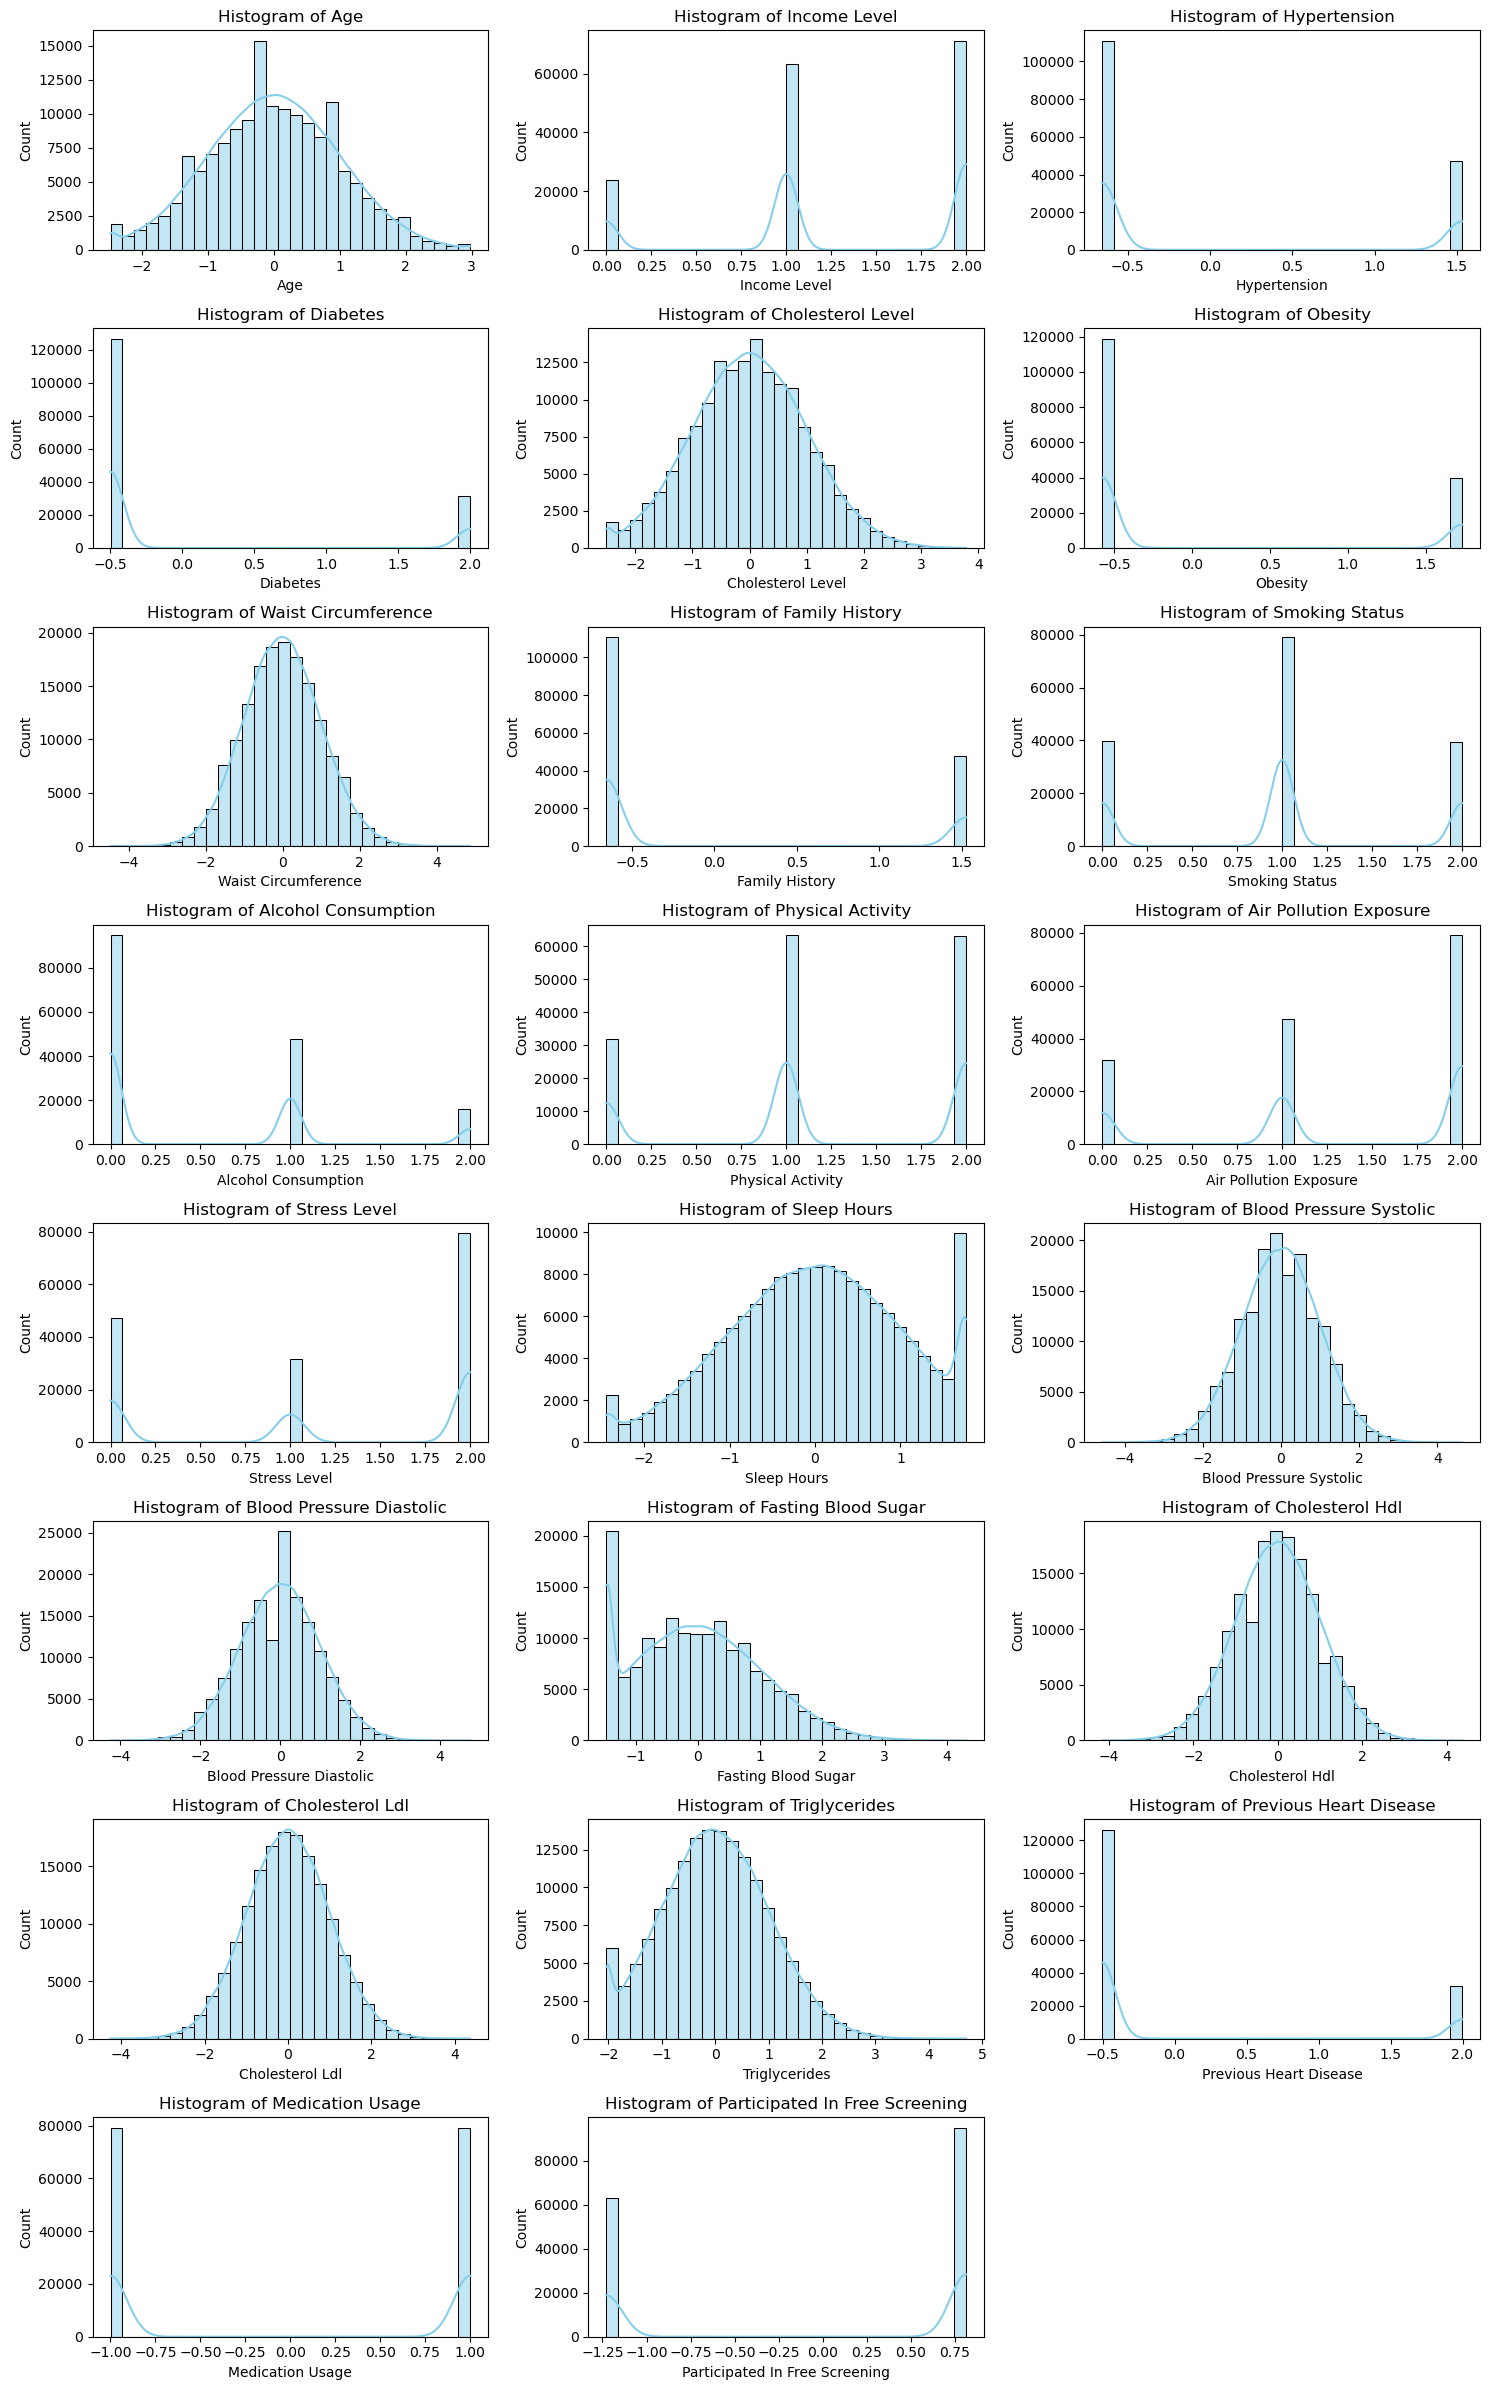


Class Distribution of heart_attack:
heart_attack
0    94854
1    63501
Name: count, dtype: int64


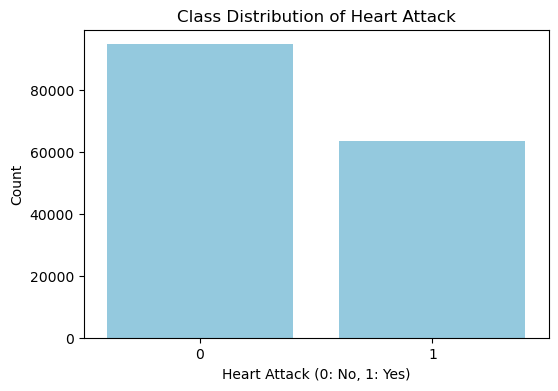

No categorical columns found for visualization.


In [5]:
from statsmodels.graphics.mosaicplot import mosaic

def explore_data(df):
    # Check missing values
    print("Missing Values:\n", df.isnull().sum())
    print("\nMissing Values Percentage:\n", (df.isnull().sum() / len(df) * 100).round(2))
    print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

    
    # Visualize numerical columns with histograms and KDE
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col != 'heart_attack']  # Exclude the target variable
    if num_cols:
        print("\nVisualizing Numerical Columns:")
        n_cols = 3  # Number of columns in the subplot grid
        n_rows = (len(num_cols) + n_cols - 1) // n_cols
        plt.figure(figsize=(n_cols * 5, n_rows * 3))
        for i, col in enumerate(num_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.histplot(df[col], kde=True, bins=30, color='skyblue')
            plt.title(f'Histogram of {col.replace("_", " ").title()}')
            plt.xlabel(col.replace('_', ' ').title())
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # Check class distribution
    print("\nClass Distribution of heart_attack:")
    print(df['heart_attack'].value_counts())
    plt.figure(figsize=(6, 4))
    sns.countplot(x='heart_attack', data=df, color='skyblue')  # Use color instead of palette
    plt.title('Class Distribution of Heart Attack')
    plt.xlabel('Heart Attack (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()

    # Visualize relationships between categorical columns and heart_attack using mosaic plots
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if not categorical_cols:
        print("No categorical columns found for visualization.")
    else:
        n_cols = 2
        n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
        plt.figure(figsize=(n_cols * 8, n_rows * 6))
        for idx, col in enumerate(categorical_cols, 1):
            plt.subplot(n_rows, n_cols, idx)
            mosaic_data = pd.crosstab(df[col], df['heart_attack'], normalize='index')
            mosaic(df, [col, 'heart_attack'], title=f'{col.replace("_", " ").title()} vs Heart Attack', 
                   axes_label=True, gap=0.02)
            plt.xlabel(col.replace('_', ' ').title())
            plt.ylabel('Heart Attack (0: No, 1: Yes)')
        plt.tight_layout()
        plt.show()

# Run EDA
explore_data(df)

## Correlation Analysis

Visualize the correlation matrix to understand relationships between features, and plot feature correlations with the target variable (`heart_attack`) to identify important predictors.

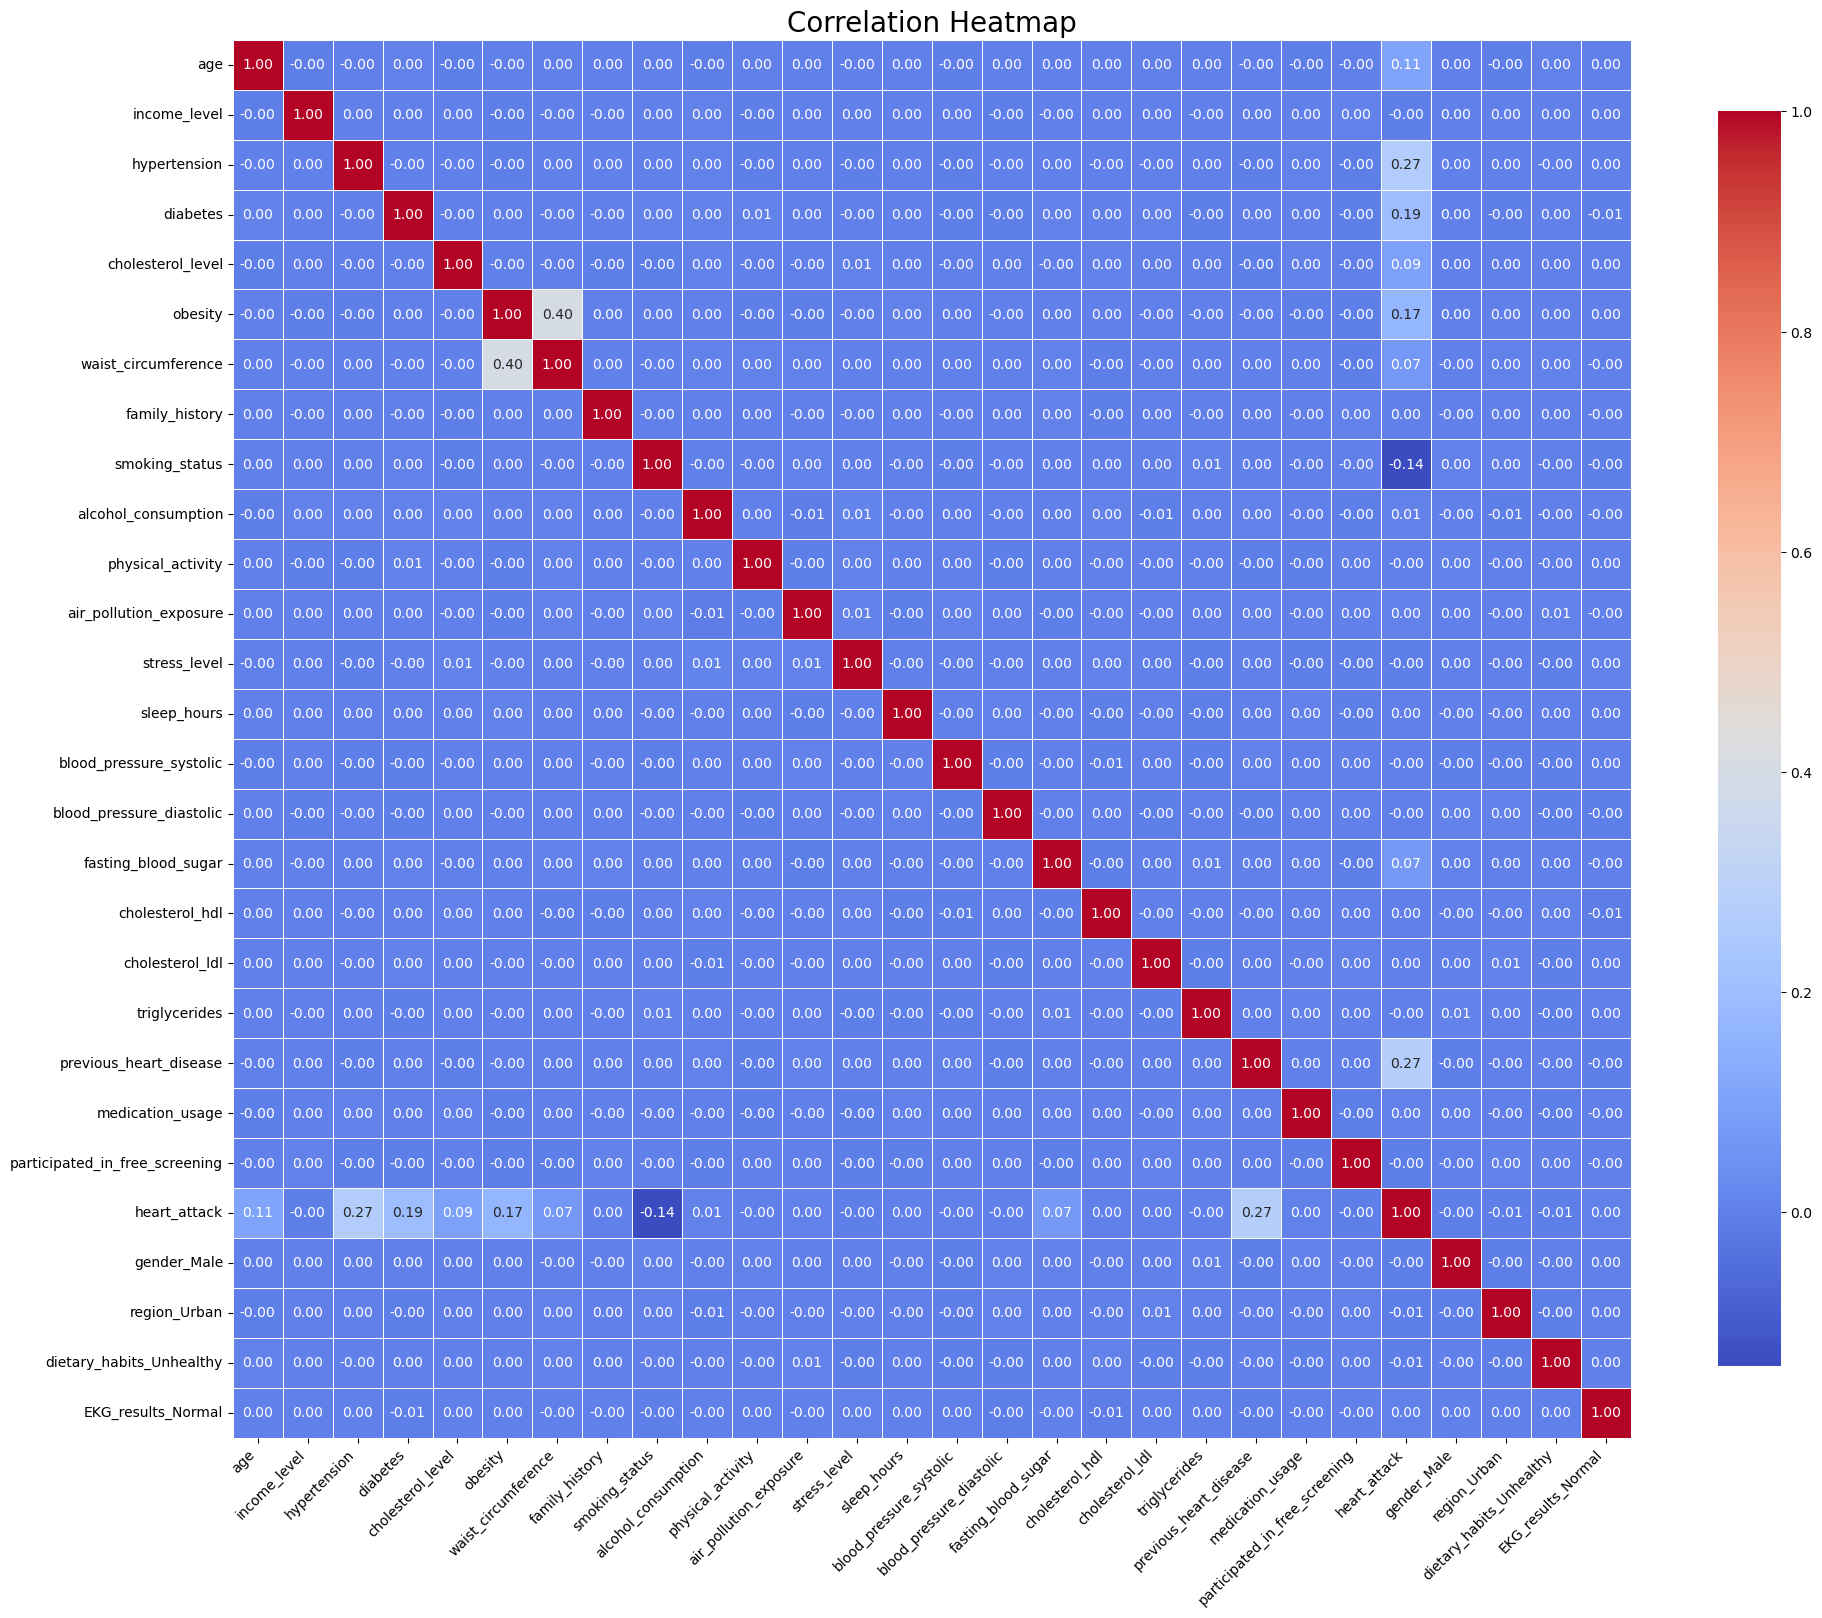

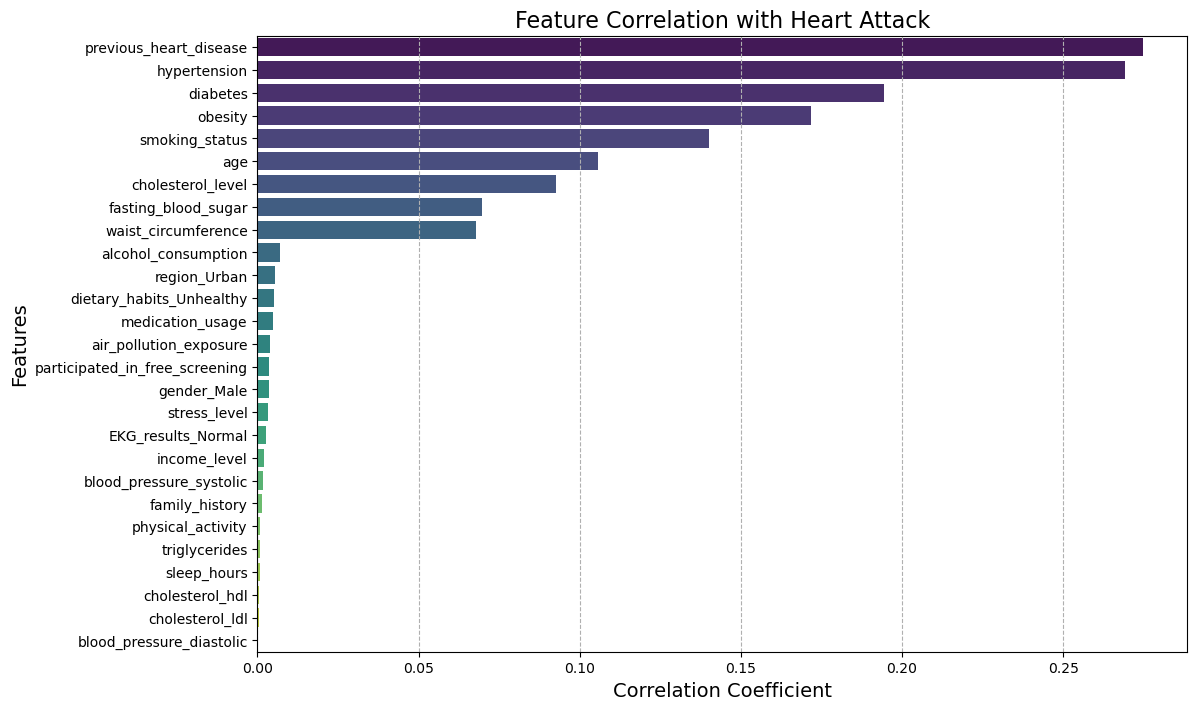

In [6]:
def visualize_correlations(df):
    # Correlation heatmap
    plt.figure(figsize=(20, 18))
    corr_matrix = df.corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title('Correlation Heatmap', fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Feature correlation with heart_attack
    target_corr = df.corr()['heart_attack'].drop('heart_attack').abs().sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=target_corr.values, y=target_corr.index, hue=target_corr.index, palette='viridis', legend=False)
    plt.title('Feature Correlation with Heart Attack', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.grid(axis='x', linestyle='--')
    plt.show()

# Run correlation visualization
visualize_correlations(df)

### Data Splitting and Confusion Matrix Plotting

In [7]:
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack']
    )
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Split the original (imbalanced) data for Experiments 1 and 2
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set size (original):", X_train.shape)
print("Testing set size:", X_test.shape)
print("Class distribution in original training set:\n", pd.Series(y_train).value_counts())

Training set size (original): (126684, 27)
Testing set size: (31671, 27)
Class distribution in original training set:
 heart_attack
0    75883
1    50801
Name: count, dtype: int64


### Experiment 1 -Baseline (Imbalanced Data)

Train a basic Logistic Regression model on the original (imbalanced) training data using `class_weight='balanced'` to handle the imbalance. Evaluate the model on the test set to establish a baseline performance.

Training set size: (126684, 27)
Testing set size: (31671, 27)
Class distribution in training set:
 heart_attack
0    75883
1    50801
Name: count, dtype: int64
Training Accuracy: 0.7180
Testing Accuracy: 0.7171

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.73      0.76     18971
           1       0.63      0.70      0.67     12700

    accuracy                           0.72     31671
   macro avg       0.71      0.71      0.71     31671
weighted avg       0.72      0.72      0.72     31671



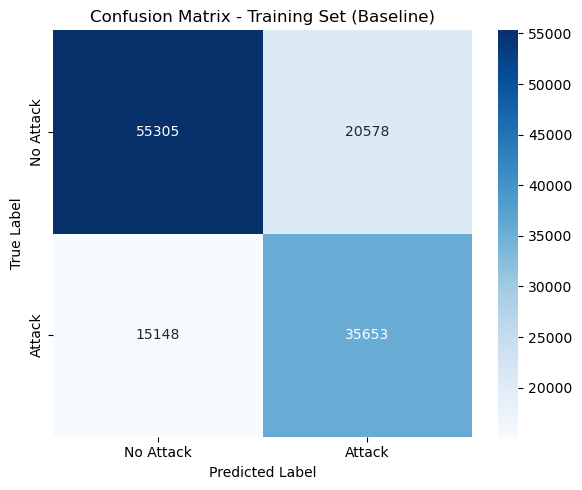

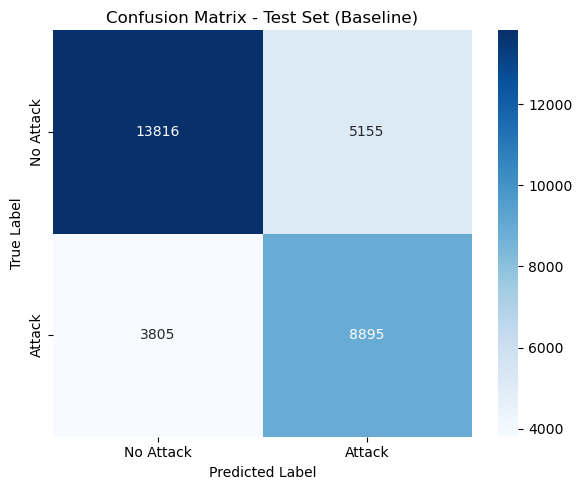

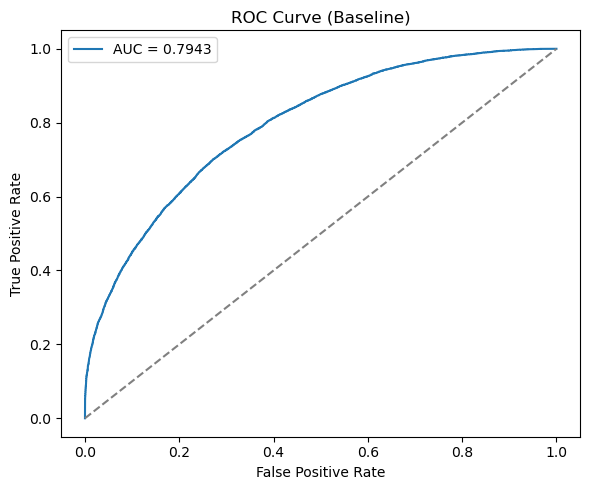


Feature Importance (absolute coefficients):
                           Feature  Importance
20          previous_heart_disease    0.720284
2                     hypertension    0.709478
8                   smoking_status    0.555187
3                         diabetes    0.519506
5                          obesity    0.466198
0                              age    0.300494
4                cholesterol_level    0.268660
16             fasting_blood_sugar    0.191383
25        dietary_habits_Unhealthy    0.029168
26              EKG_results_Normal    0.026549
23                     gender_Male    0.021934
24                    region_Urban    0.019086
9              alcohol_consumption    0.017422
21                medication_usage    0.015917
11          air_pollution_exposure    0.009847
22  participated_in_free_screening    0.007998
12                    stress_level    0.007850
10               physical_activity    0.005588
14         blood_pressure_systolic    0.005163
7              

In [8]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Class distribution in training set:\n", pd.Series(y_train).value_counts())


# Initialize and train Logistic Regression model with default values
model_baseline = LogisticRegression(
    max_iter=500,  # Adjusted to ensure convergence (default is 100)
    class_weight='balanced',  # Adjusted to handle imbalance (default is None)
    random_state=42  # Adjusted for reproducibility (default is None)
    # All other parameters use defaults:
    # solver='lbfgs', penalty='l2', C=1.0, fit_intercept=True, tol=1e-4, etc.
)
model_baseline.fit(X_train, y_train)

# Predictions
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
plot_conf_matrix(train_cm, "Confusion Matrix - Training Set (Baseline)")
plot_conf_matrix(test_cm, "Confusion Matrix - Test Set (Baseline)")

# ROC Curve
y_test_prob = model_baseline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (Baseline)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(model_baseline.coef_[0])
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (absolute coefficients):")
print(importances)

# Store the test accuracy for comparison
acc_baseline = test_accuracy

### Experiment 2 - SMOTE

Use SMOTE to oversample the minority class in the training data, creating a balanced dataset.

Training set size (before SMOTE): (126684, 27)
Class distribution in training set (before SMOTE):
 heart_attack
0    75883
1    50801
Name: count, dtype: int64

Training set size (after SMOTE): (151766, 27)
Class distribution in training set (after SMOTE):
 heart_attack
0    75883
1    75883
Name: count, dtype: int64

Training Accuracy (SMOTE): 0.7292
Testing Accuracy (SMOTE): 0.7118

Classification Report (Test Set - SMOTE):
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     18971
           1       0.63      0.67      0.65     12700

    accuracy                           0.71     31671
   macro avg       0.70      0.71      0.70     31671
weighted avg       0.72      0.71      0.71     31671



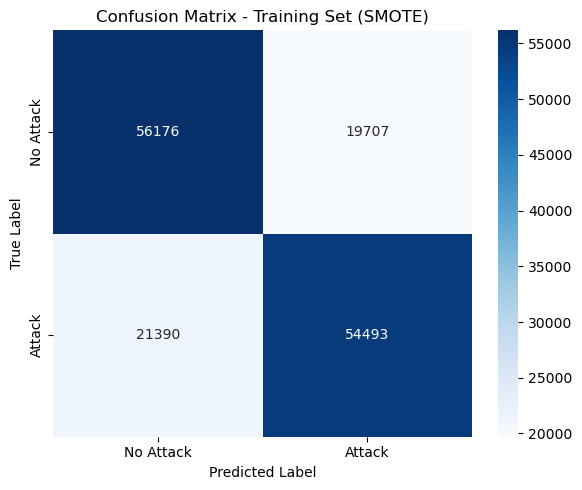

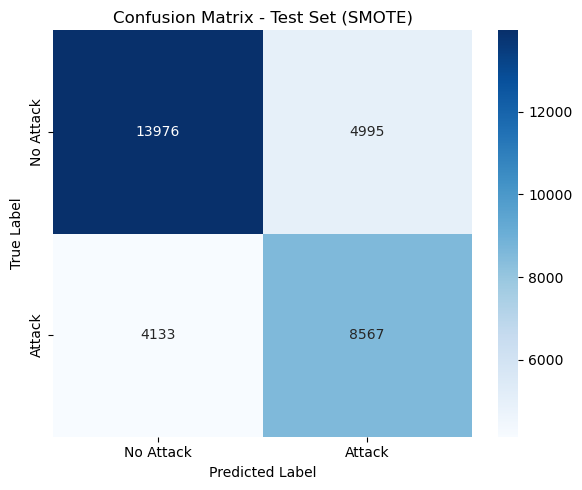

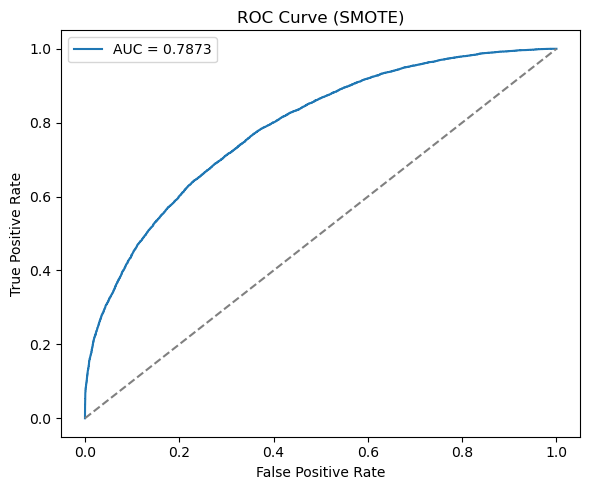


Feature Importance (SMOTE, absolute coefficients):
                           Feature  Importance
20          previous_heart_disease    0.731510
2                     hypertension    0.722201
8                   smoking_status    0.713029
3                         diabetes    0.529422
5                          obesity    0.471577
0                              age    0.317828
26              EKG_results_Normal    0.300292
4                cholesterol_level    0.277248
24                    region_Urban    0.219179
16             fasting_blood_sugar    0.194452
25        dietary_habits_Unhealthy    0.191685
23                     gender_Male    0.179036
9              alcohol_consumption    0.134541
10               physical_activity    0.110946
1                     income_level    0.110454
11          air_pollution_exposure    0.069812
12                    stress_level    0.057900
21                medication_usage    0.015014
22  participated_in_free_screening    0.005658
19      

In [12]:
# Imports for SMOTE
from imblearn.over_sampling import SMOTE

print("Training set size (before SMOTE):", X_train.shape)
print("Class distribution in training set (before SMOTE):\n", pd.Series(y_train).value_counts())

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nTraining set size (after SMOTE):", X_train_smote.shape)
print("Class distribution in training set (after SMOTE):\n", pd.Series(y_train_smote).value_counts())

# Initialize and train Logistic Regression model
model_smote = LogisticRegression(
    max_iter=500, 
    class_weight=None,  # No need for class_weight since SMOTE balances classes
    solver='liblinear', 
    random_state=42
)
model_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_train_pred_smote = model_smote.predict(X_train_smote)
y_test_pred_smote = model_smote.predict(X_test)

# Accuracy
train_accuracy_smote = accuracy_score(y_train_smote, y_train_pred_smote)
test_accuracy_smote = accuracy_score(y_test, y_test_pred_smote)
print(f"\nTraining Accuracy (SMOTE): {train_accuracy_smote:.4f}")
print(f"Testing Accuracy (SMOTE): {test_accuracy_smote:.4f}")

# Classification Report
print("\nClassification Report (Test Set - SMOTE):")
print(classification_report(y_test, y_test_pred_smote))

# Confusion Matrices
train_cm_smote = confusion_matrix(y_train_smote, y_train_pred_smote)
test_cm_smote = confusion_matrix(y_test, y_test_pred_smote)
plot_conf_matrix(train_cm_smote, "Confusion Matrix - Training Set (SMOTE)")
plot_conf_matrix(test_cm_smote, "Confusion Matrix - Test Set (SMOTE)")

# ROC Curve
y_test_prob_smote = model_smote.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_test_prob_smote)
roc_auc_smote = roc_auc_score(y_test, y_test_prob_smote)
plt.figure(figsize=(6, 5))
plt.plot(fpr_smote, tpr_smote, label=f'AUC = {roc_auc_smote:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance
importances_smote = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(model_smote.coef_[0])
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (SMOTE, absolute coefficients):")
print(importances_smote)

# Store the test accuracy for comparison
acc_smote = test_accuracy_smote

### Experiment 3 - Downsampling

Use the downsampled (balanced) training data to train a Logistic Regression model. Evaluate on the original test set to ensure consistency across experiments.

Class distribution in downsampled dataset:
 heart_attack
0    63501
1    63501
Name: count, dtype: int64

Training set size (downsampled): (101601, 27)
Testing set size (downsampled): (25401, 27)
Class distribution in training set (downsampled):
 heart_attack
1    50801
0    50800
Name: count, dtype: int64

Training Accuracy (Downsampled): 0.7151
Testing Accuracy (Downsampled): 0.7143

Classification Report (Test Set - Downsampled):
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     12701
           1       0.72      0.70      0.71     12700

    accuracy                           0.71     25401
   macro avg       0.71      0.71      0.71     25401
weighted avg       0.71      0.71      0.71     25401



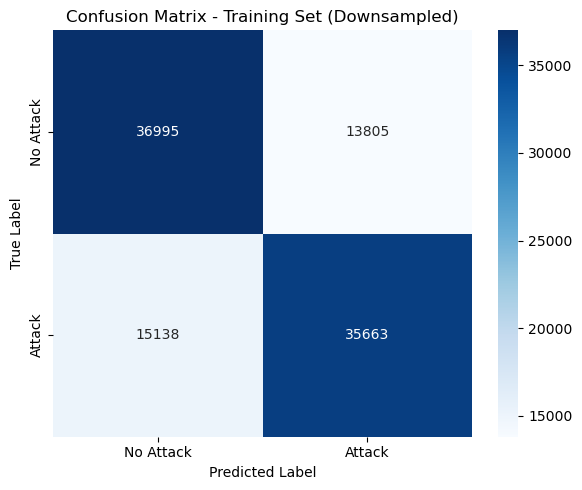

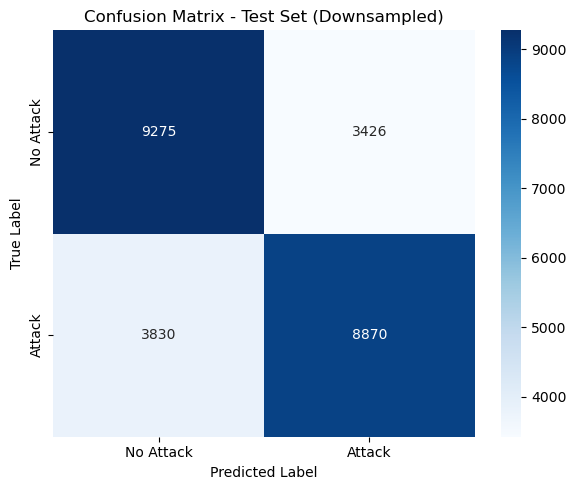

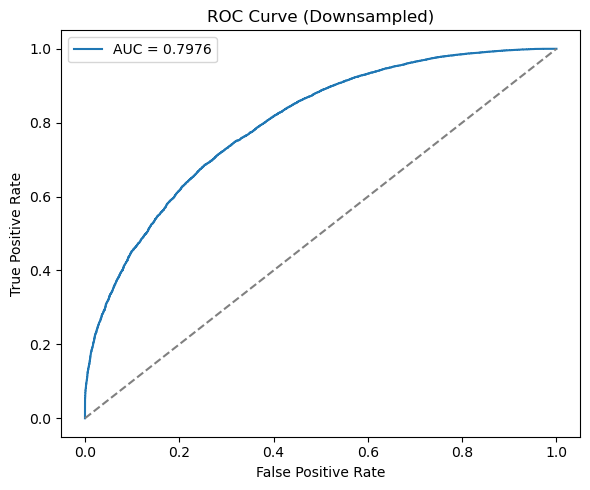


Feature Importance (Downsampled, absolute coefficients):
                           Feature  Importance
20          previous_heart_disease    0.720619
2                     hypertension    0.703581
8                   smoking_status    0.551666
3                         diabetes    0.507897
5                          obesity    0.460760
0                              age    0.296494
4                cholesterol_level    0.264501
16             fasting_blood_sugar    0.189763
26              EKG_results_Normal    0.035876
23                     gender_Male    0.028344
25        dietary_habits_Unhealthy    0.026150
24                    region_Urban    0.023376
11          air_pollution_exposure    0.020525
9              alcohol_consumption    0.019623
21                medication_usage    0.014760
1                     income_level    0.011598
12                    stress_level    0.010298
19                   triglycerides    0.003950
6              waist_circumference    0.003458
15

In [10]:
# Imports for downsampling
from sklearn.utils import resample

# Downsample the majority class
df_majority = df[df['heart_attack'] == 0]
df_minority = df[df['heart_attack'] == 1]
df_majority_downsampled = resample(
    df_majority, 
    replace=False, 
    n_samples=len(df_minority), 
    random_state=42
)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print("Class distribution in downsampled dataset:\n", df_downsampled['heart_attack'].value_counts())

# Split the downsampled data
X_downsampled = df_downsampled.drop(columns=['heart_attack'])
y_downsampled = df_downsampled['heart_attack']
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(
    X_downsampled, y_downsampled, test_size=0.2, random_state=42, stratify=y_downsampled
)
print("\nTraining set size (downsampled):", X_train_down.shape)
print("Testing set size (downsampled):", X_test_down.shape)
print("Class distribution in training set (downsampled):\n", pd.Series(y_train_down).value_counts())

# Initialize and train Logistic Regression model
model_down = LogisticRegression(
    max_iter=500, 
    class_weight=None,  # No need for class_weight since data is balanced 
    random_state=42
)
model_down.fit(X_train_down, y_train_down)

# Predictions
y_train_pred_down = model_down.predict(X_train_down)
y_test_pred_down = model_down.predict(X_test_down)

# Accuracy
train_accuracy_down = accuracy_score(y_train_down, y_train_pred_down)
test_accuracy_down = accuracy_score(y_test_down, y_test_pred_down)
print(f"\nTraining Accuracy (Downsampled): {train_accuracy_down:.4f}")
print(f"Testing Accuracy (Downsampled): {test_accuracy_down:.4f}")

# Classification Report
print("\nClassification Report (Test Set - Downsampled):")
print(classification_report(y_test_down, y_test_pred_down))

# Confusion Matrices
train_cm_down = confusion_matrix(y_train_down, y_train_pred_down)
test_cm_down = confusion_matrix(y_test_down, y_test_pred_down)
plot_conf_matrix(train_cm_down, "Confusion Matrix - Training Set (Downsampled)")
plot_conf_matrix(test_cm_down, "Confusion Matrix - Test Set (Downsampled)")

# ROC Curve
y_test_prob_down = model_down.predict_proba(X_test_down)[:, 1]
fpr_down, tpr_down, _ = roc_curve(y_test_down, y_test_prob_down)
roc_auc_down = roc_auc_score(y_test_down, y_test_prob_down)
plt.figure(figsize=(6, 5))
plt.plot(fpr_down, tpr_down, label=f'AUC = {roc_auc_down:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (Downsampled)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance
importances_down = pd.DataFrame({
    'Feature': X_train_down.columns,
    'Importance': np.abs(model_down.coef_[0])
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Downsampled, absolute coefficients):")
print(importances_down)

# Store the test accuracy for comparison
acc_down = test_accuracy_down

### Experiment 4 - Hyperparameter Tuning with GridSearchCV

Use the downsampled training data to perform hyperparameter tuning with GridSearchCV. Tune the hyperparameters `C` (regularization strength) and `penalty` (l1 or l2), then train a Logistic Regression model with the best parameters. Evaluate on the original test set.

Training set size (downsampled): (101601, 27)
Testing set size (downsampled): (25401, 27)

Best Parameters: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best Cross-Validation F1-Score: 0.7109323210662802

Training Accuracy (Tuned): 0.7151
Testing Accuracy (Tuned): 0.7142
Training Balanced Accuracy (Tuned): 0.7151
Testing Balanced Accuracy (Tuned): 0.7142
Training F1-Score (Tuned): 0.7114
Testing F1-Score (Tuned): 0.7095

Classification Report (Test Set - Tuned):
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     12701
           1       0.72      0.70      0.71     12700

    accuracy                           0.71     25401
   macro avg       0.71      0.71      0.71     25401
weighted avg       0.71      0.71      0.71     25401



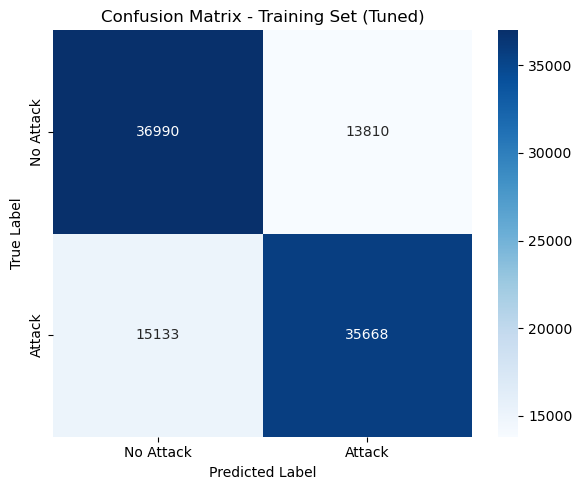

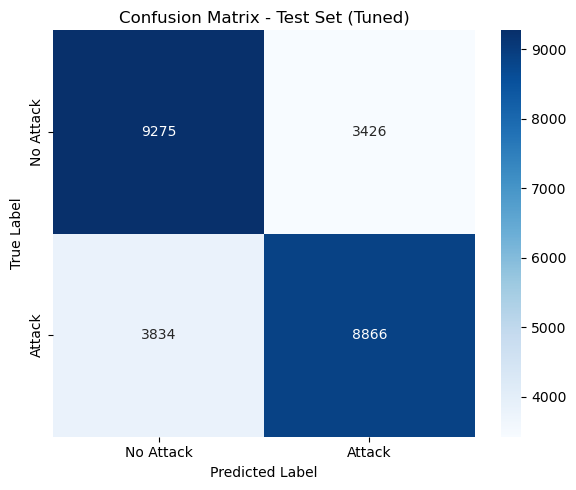

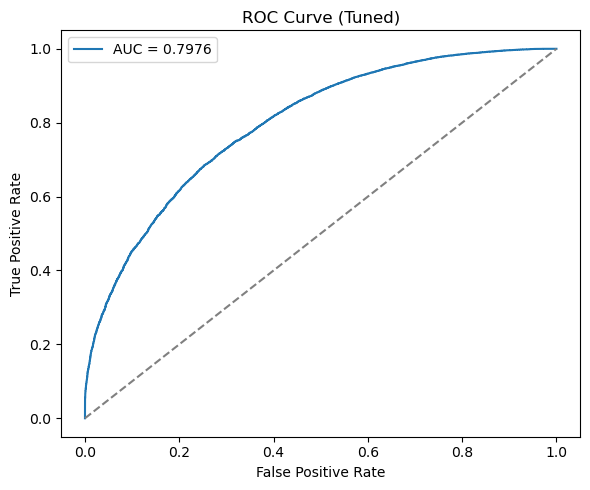


Feature Importance (Tuned, absolute coefficients):
                           Feature  Importance
20          previous_heart_disease    0.720852
2                     hypertension    0.703954
8                   smoking_status    0.551311
3                         diabetes    0.508279
5                          obesity    0.461120
0                              age    0.296208
4                cholesterol_level    0.264380
16             fasting_blood_sugar    0.189844
26              EKG_results_Normal    0.035664
23                     gender_Male    0.028092
25        dietary_habits_Unhealthy    0.025550
24                    region_Urban    0.021862
11          air_pollution_exposure    0.020244
9              alcohol_consumption    0.019204
21                medication_usage    0.014687
1                     income_level    0.012194
12                    stress_level    0.010402
6              waist_circumference    0.003884
19                   triglycerides    0.003801
22  part

In [11]:
# Imports for Grid Search and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score, 
    balanced_accuracy_score, 
    f1_score
)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use the downsampled data from Experiment 3
print("Training set size (downsampled):", X_train_down.shape)
print("Testing set size (downsampled):", X_test_down.shape)

# Define an optimized parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 20],  # Finer granularity and extended range
    'penalty': ['l1', 'l2'],             # Both regularization types
    'solver': ['liblinear', 'saga'],     # Solvers that support both l1 and l2 penalties
    'tol': [1e-4, 5e-4, 1e-3],          # Convergence tolerance for fine-tuning
    'max_iter': [1000]                   # Ensure convergence
}

# Initialize Logistic Regression model with a default solver that supports both penalties
model_tuned = LogisticRegression(random_state=42)

# Perform Grid Search with f1-score as the primary metric
grid_search = GridSearchCV(
    estimator=model_tuned,
    param_grid=param_grid,
    cv=5,                        # 5-fold CV for efficiency
    scoring='f1',                # Optimize for F1-score
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_down, y_train_down)

# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1-Score:", grid_search.best_score_)

# Train the model with the best parameters
model_tuned = grid_search.best_estimator_
model_tuned.fit(X_train_down, y_train_down)

# Predictions
y_train_pred_tuned = model_tuned.predict(X_train_down)
y_test_pred_tuned = model_tuned.predict(X_test_down)

# Evaluate multiple metrics
train_accuracy_tuned = accuracy_score(y_train_down, y_train_pred_tuned)
test_accuracy_tuned = accuracy_score(y_test_down, y_test_pred_tuned)
train_balanced_accuracy = balanced_accuracy_score(y_train_down, y_train_pred_tuned)
test_balanced_accuracy = balanced_accuracy_score(y_test_down, y_test_pred_tuned)
train_f1 = f1_score(y_train_down, y_train_pred_tuned)
test_f1 = f1_score(y_test_down, y_test_pred_tuned)

print(f"\nTraining Accuracy (Tuned): {train_accuracy_tuned:.4f}")
print(f"Testing Accuracy (Tuned): {test_accuracy_tuned:.4f}")
print(f"Training Balanced Accuracy (Tuned): {train_balanced_accuracy:.4f}")
print(f"Testing Balanced Accuracy (Tuned): {test_balanced_accuracy:.4f}")
print(f"Training F1-Score (Tuned): {train_f1:.4f}")
print(f"Testing F1-Score (Tuned): {test_f1:.4f}")

# Classification Report
print("\nClassification Report (Test Set - Tuned):")
print(classification_report(y_test_down, y_test_pred_tuned))

# Confusion Matrices
train_cm_tuned = confusion_matrix(y_train_down, y_train_pred_tuned)
test_cm_tuned = confusion_matrix(y_test_down, y_test_pred_tuned)
plot_conf_matrix(train_cm_tuned, "Confusion Matrix - Training Set (Tuned)")
plot_conf_matrix(test_cm_tuned, "Confusion Matrix - Test Set (Tuned)")

# ROC Curve
y_test_prob_tuned = model_tuned.predict_proba(X_test_down)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_down, y_test_prob_tuned)
roc_auc_tuned = roc_auc_score(y_test_down, y_test_prob_tuned)
plt.figure(figsize=(6, 5))
plt.plot(fpr_tuned, tpr_tuned, label=f'AUC = {roc_auc_tuned:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (Tuned)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance
importances_tuned = pd.DataFrame({
    'Feature': X_train_down.columns,
    'Importance': np.abs(model_tuned.coef_[0])
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Tuned, absolute coefficients):")
print(importances_tuned)

# Store the test metrics for comparison
acc_tuned = test_accuracy_tuned
balanced_acc_tuned = test_balanced_accuracy
f1_tuned = test_f1
auc_tuned = roc_auc_tuned